<div class="alert alert-block alert-info">
<p style="font-size:24px;text-align:center"><b>Propagate a low-resolution SRW generated Gaussian wavefront through a thin lens.</b>
</div>

In [1]:
import array
import math
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import os

from pykern.pkcollections import PKDict
# The rslaser library may not be installed, so a check is required.
try:
    import rslaser
except:
    print("The rslaser library was not found; installing from GitHub...")
    # Developers should use 'pip install -e .' from the command line.
    # Users can install directly from GitHub --
    !{sys.executable} -m pip install git+https://github.com/radiasoft/rslaser.git
    import rslaser
from rslaser.optics import wavefront
from rslaser.optics import element
from rslaser.utils import merit_functions
from rslaser.pulse import pulse

import scipy
from scipy import constants, ndimage, stats
from scipy.ndimage.filters import gaussian_filter

# SRW and srwlib (the corresponding Python API) are pre-installed on Sirepo/Jupyter
import srwlib
from srwlib import srwl

In [2]:
# 2D plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

# reset the notebook style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Specify whether 2D and/or 3D plots should be rendered
RENDER_2D_PLOTS = True
RENDER_3D_PLOTS = False

# 3D plotting
if RENDER_3D_PLOTS:
    import plotly.graph_objects as go

In [3]:
def rms_calc_2d(_x, _y, f_dist):
    """
    Calculate the x and y averages and RMS of a 2d distribution f_dist(x,y)

    Args:
        _x, 2d numpy array that defines x values of the distribution
        _y, 2d numpy array that defines y values of the distribution
        f_dist, 2d numpy array that defines the x,y distribution
    
    Returns:
        x_avg, y_avg, the average values of x and y
        x_rms, y_rms, the RMS values of x and y

    Example:
        >>> xavg, yavg, xrms, yrms = rms_calc_2d(my_array)
    """
    x_f = np.multiply(_x, f_dist)
    y_f = np.multiply(_y, f_dist)
    sum_f = np.sum(f_dist)
    x_avg = np.sum(x_f) / sum_f
    y_avg = np.sum(y_f) / sum_f

    xsq_f = np.multiply(_x, x_f)
    ysq_f = np.multiply(_y, y_f)
    x_std = np.sum(xsq_f) / sum_f
    y_std = np.sum(ysq_f) / sum_f

    x_rms = math.sqrt(x_std - x_avg**2)
    y_rms = math.sqrt(y_std - y_avg**2)
    return x_avg, y_avg, x_rms, y_rms

In [4]:
# instantiate a laser pulse
x_rms = 5.0e-04 # [m]
y_rms = x_rms
_w0 = 2. * x_rms
    
# photon energy corresponding to lambda = 1 micron
_LASER_PULSE_SLICE = PKDict(
    sigrW = math.sqrt(x_rms*y_rms),
    propLen = 15,
    pulseE = 0.001,
    poltype = 1,
    sampFact = 0.018,
    mx = 0,
    my = 0
)
_LASER_PULSE = PKDict(
        phE = 1.55,
        nslice = 1,
        chirp = 0,
        w0 = _w0,
        a0 = .002,
        dw0x = 0.0,
        dw0y = 0.0,
        z_waist = -0.1,
        dzwx = 0.0,
        dzwy = 0.0,
        tau_fwhm = 0.1 / constants.c / math.sqrt(2.),
        z_center = 0.,
        x_shift = 0.,
        y_shift = 0.,
        d_to_w = 0.1,
        slice_params=_LASER_PULSE_SLICE,
)

In [5]:
# instantiate the laser pulse (this can take a few seconds)
in_pulse = PKDict(
    **_LASER_PULSE
    )
LP = pulse.LaserPulse(in_pulse)
wfr0 = LP.slice[0].wfr

In [6]:
# create the x,y arrays
x_max = LP.slice[0].wfr.mesh.xFin
x_min = LP.slice[0].wfr.mesh.xStart
nx = LP.slice[0].wfr.mesh.nx
x1 = np.linspace(x_min, x_max, nx)

y_max = LP.slice[0].wfr.mesh.yFin
y_min = LP.slice[0].wfr.mesh.yStart
ny = LP.slice[0].wfr.mesh.ny
y1 = np.linspace(y_min, y_max, ny)

x, y = np.meshgrid(x1, y1)

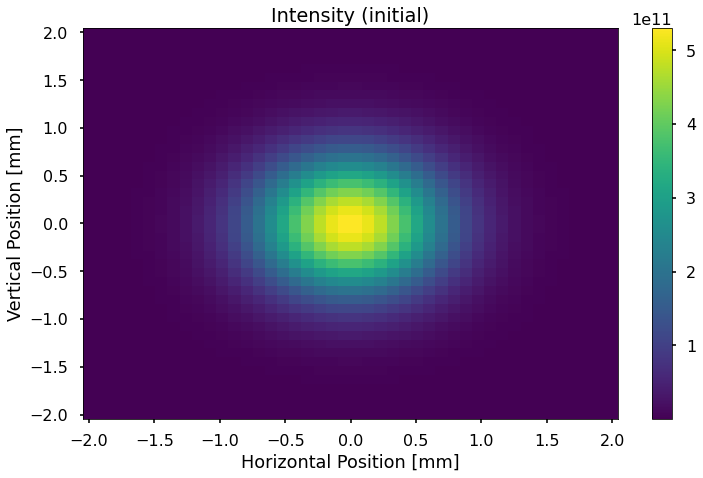

In [7]:
#Plot initial wavefront
##Initial wfr calculation
arIinit = srwlib.array('f', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(arIinit, wfr0, 6, 0, 3, wfr0.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
arIinit2D = np.array(arIinit).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsizei=np.size(arIinit)

if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, arIinit2D, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (initial)')

In [8]:
# initial phase
phase0 = srwlib.array('d', [0]*wfr0.mesh.nx*wfr0.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase0, wfr0, 0, 4, 3, wfr0.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_0 = np.array(phase0).reshape((wfr0.mesh.nx, wfr0.mesh.ny), order='C')
wfrsize=np.size(phase0)

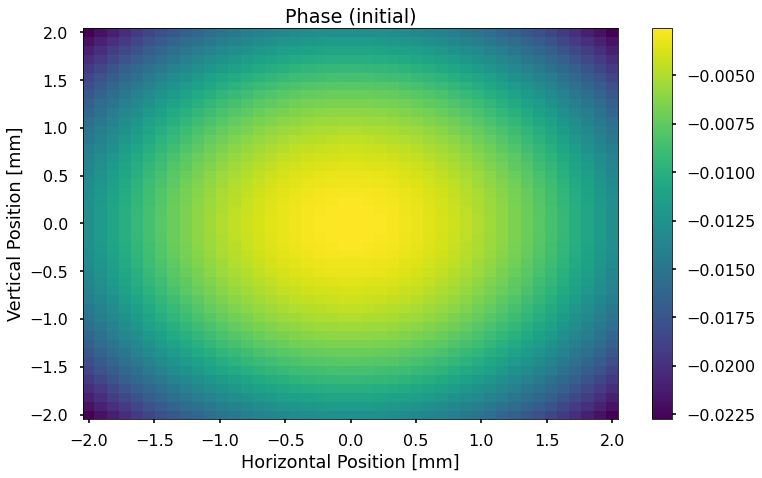

In [9]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7.2))
        ax = fig.gca()
        plt.pcolormesh(x*1e3, y*1e3, phase_2d_0, cmap=plt.cm.viridis, shading='auto')
        plt.colorbar()
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_title('Phase (initial)')

In [10]:
# interesting to know the wavefront centroid and rms properties
x_avg, y_avg, x_rms, y_rms = rms_calc_2d(x, y, arIinit2D)

print(' x_avg = {0:4.2e} [m]'.format(x_avg))
print(' y_avg = {0:4.2e} [m]'.format(y_avg))
print(' ')
print(' x_rms = {0:4.2e} [m]'.format(x_rms))
print(' y_rms = {0:4.2e} [m]'.format(y_rms))

 x_avg = 3.95e-20 [m]
 y_avg = 0.00e+00 [m]
 
 x_rms = 5.00e-04 [m]
 y_rms = 5.00e-04 [m]


<div class="alert alert-block alert-info">
<p style="font-size:18px;">Create a simple focusing lens and propagate the laser pulse.</p>
</div>

In [11]:
# instantiate a simple focusing lens
focal_length = 1.   # [m]
lattice_lens = [(element.Lens(focal_length),'default')]

# propagate the pulse through the lattice
for iterator in lattice_lens:
    current_elem, prop_type = iterator
    LP = current_elem.propagate(LP, prop_type)

In [12]:
# transmitted pulse - intensity
wfr2=LP.slice[0].wfr

intensity2 = srwlib.array('f', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(intensity2, wfr2, 0, 0, 3, wfr2.mesh.eStart, 0, 0) #extracts intensity

##Reshaping electric field data from flat to 2D array
intens_2d_2 = np.array(intensity2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsizei=np.size(intensity2)

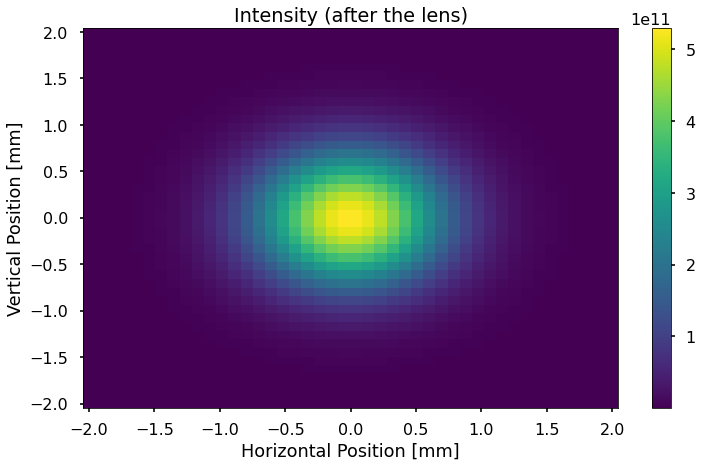

In [13]:
# plot the computed intensity
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x*1e3, y*1e3, intens_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Intensity (after the lens)')

In [14]:
# transmitted pulse - phase
phase2 = srwlib.array('d', [0]*wfr2.mesh.nx*wfr2.mesh.ny) # "flat" array to take 2D intensity data
srwl.CalcIntFromElecField(phase2, wfr2, 0, 4, 3, wfr2.mesh.eStart, 0, 0) #extracts the phase; must use double precision

##Reshaping electric field data from flat to 2D array
phase_2d_2 = np.array(phase2).reshape((wfr2.mesh.nx, wfr2.mesh.ny), order='C')
wfrsize=np.size(phase2)

print('Size of initial wavefront data array (coordinate):',np.shape(phase_2d_2))
x2=np.linspace(wfr2.mesh.xStart,wfr2.mesh.xFin,wfr2.mesh.nx)
y2=np.linspace(wfr2.mesh.yStart,wfr2.mesh.yFin,wfr2.mesh.ny)

# print(' ')
# print(' phase_2d_2 = ', phase_2d_2)

Size of initial wavefront data array (coordinate): (44, 44)


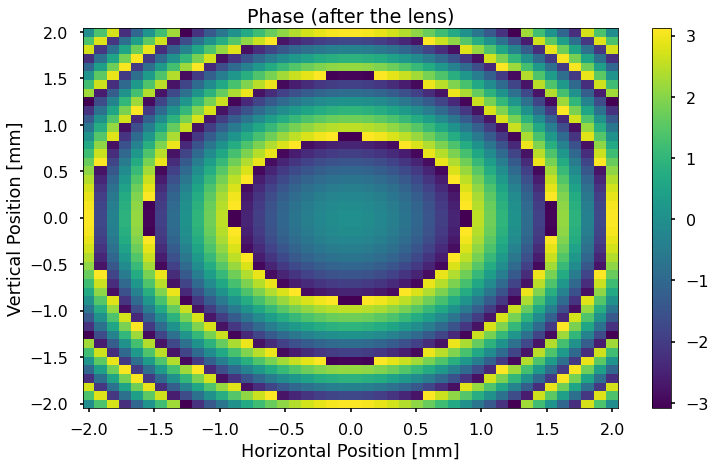

In [15]:
# plot the phase
if RENDER_2D_PLOTS:
    with plt.style.context(('seaborn-poster')):
        fig = plt.figure(figsize=(12,7))
        ax = fig.gca()

        # By setting wfr0a.unitElFldAng=1, default units should  now be in mrad(?)
        plt.pcolormesh(x*1e3, y*1e3, phase_2d_2, cmap=plt.cm.viridis,shading='auto')
        plt.colorbar()
        ax.set_ylabel(r'Vertical Position [mm]')
        ax.set_xlabel(r'Horizontal Position [mm]')
        ax.set_title('Phase (after the lens)')